In [1]:
from discriminator.dis import Dis
from cascade.model import CascadeNet
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
from utils import *
from mri_utils import *
import os
import torchvision
from skimage.measure import compare_ssim as ssim

In [2]:
# %matplotlib qt
G = CascadeNet().cuda() # input channels:  Z(X) x Y -> output channel X

In [3]:
# mri_test = MRIDataSet('../data/CORRECTED_COMBINED_bilkent_20_validation.mat')
# dataloader_test = DataLoader(mri_test, batch_size=1)

In [4]:
# x, y, mask = next(iter(dataloader_test))

In [5]:
x = torch.load('../data/x.pt')
ms = torch.load('../data/ms.pt')
g_mask = torch.load('../data/uncertainty_descent/mask_20.pt')

In [6]:
masks = ['gaussianMask1D([256,256],0.1,10,density_std=0.08,scale_up=0.05)',

         'gaussianMask1D([256,256],0.15,12,density_std=0.12,scale_up=0.05)',

        'gaussianMask1D([256,256],0.2,12,density_std=0.16,scale_up=0.05)',

        'gaussianMask1D([256,256],0.25,14,density_std=0.18,scale_up=0.1)',

        'gaussianMask1D([256,256],0.3,14,density_std=0.18,scale_up=0.15)',

         'gaussianMask1D([256,256],0.35,16,density_std=0.2,scale_up=0.2)',

        'gaussianMask1D([256,256],0.4,18,density_std=0.2,scale_up=0.25)',

         'gaussianMask1D([256,256],0.45,20,density_std=0.2,scale_up=0.3)',

        'gaussianMask1D([256,256],0.5,22,density_std=0.2,scale_up=0.35)']
mask = ms #eval(masks[0])
y1 = backward_op(forward_op(to5d(x),mask))

In [7]:
def psnr(img, r_img):
    return 10*torch.log10(torch.max(r_img)**2/torch.mean((img-r_img)**2))

# Results for test data

In [8]:
idx =1999
G.load_state_dict(torch.load('./parameters/checkpoint%d/G.pt'%(idx)))

In [9]:
# mse = []
# for i, (gt, observed) in enumerate(loader):
#     outps = []
#     for j in range(100):
#         zv = torch.rand((1, 2, 256, 256)).cuda()
#         observedv = observed.reshape((1,2,256,256)).cuda()
#         inpv = torch.cat((zv, observedv), 1)
#         outps.append(G(inpv).cpu().detach().numpy())
#     outps = np.concatenate(outps)
#     mean = np.mean(outps,0)
#     mse.append(np.mean((mean-gt.numpy())**2))
#     print('%d '%(i), end='')
# print('mse: %e'%(np.mean(mse)))

In [10]:
# img_idx =3
G.eval()
outps1 = []
for i in range(10):
    zv = torch.rand((1, 2, 256, 256)).cuda()
    observedv = y1.reshape((1,2,256,256)).cuda()
    inpv = torch.cat((observedv, zv), 1)
    outps1.append(G(inpv, torch.unsqueeze(mask, 0).cuda()).cpu().detach().numpy())

outps1 = np.concatenate(outps1)
mean1 = np.mean(outps1,0)
var1 = np.var(outps1,0)

In [11]:
fs = []
for i in range(10):
    zv = torch.rand((1, 2, 256, 256)).cuda()
    observedv = y1.cuda()
    inpv = torch.cat((observedv, zv), 1)
    fs.append(torch.fft(to5d(G(inpv, torch.unsqueeze(mask, 0).cuda()).cpu().detach()), signal_ndim = 2,normalized=True))

fs = torch.cat(fs, 0)
f_var = torch.var(fs, 0)
f_var = f_var[0,:,:,0] +  f_var[0,:,:,1]
# f_std = torch.sqrt(f_var)

f_predict = torch.mean(fs, 0, keepdim=True)
f_mean = tensor_abs(f_predict)[0,0,:,:]

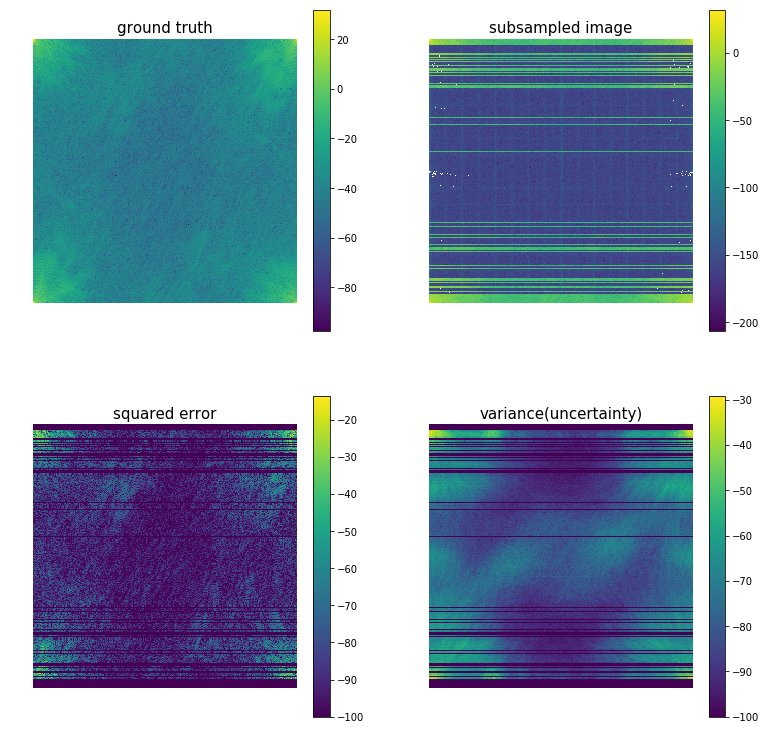

In [47]:

plt.figure(figsize=(13,13))
plt.subplot(221)
fx = tensor_abs(torch.fft(to5d(x), signal_ndim = 2, normalized=True))[0,0]
plt.imshow(20*torch.log10(fx))
plt.title('ground truth',fontsize=15)
plt.colorbar()
plt.axis('off')

plt.subplot(222)
fy = tensor_abs(torch.fft(to5d(y1), signal_ndim = 2, normalized=True))[0,0]
plt.imshow(20*torch.log10(fy))
plt.title('subsampled image',fontsize=15)
plt.colorbar()
plt.axis('off')

plt.subplot(223)
plt.imshow(20*torch.log10((f_mean-fx)**2+1e-5))
plt.colorbar()
plt.title('squared error',fontsize=15)
plt.axis('off')

plt.subplot(224)
plt.imshow(20*torch.log10(f_var+1e-5))
plt.colorbar()
plt.title('variance(uncertainty)',fontsize=15)
plt.axis('off')
plt.savefig('./results/freq_1d_gaussian.pdf')

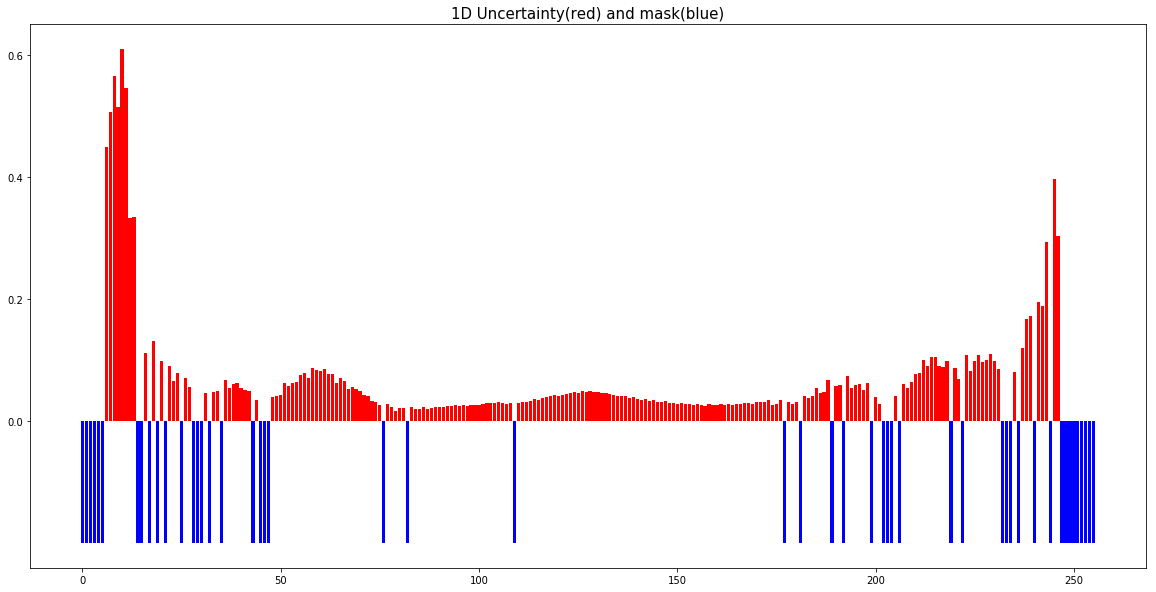

In [32]:
plt.figure(figsize=(20,10))
# plt.subplot(211)
plt.bar(np.arange(256), -0.2*(torch.sum(mask,1)>0).float(),color='b')
plt.title('mask',fontsize=10)
# plt.subplot(212)
plt.bar(np.arange(256), torch.sum(f_var, 1),color='r')
plt.yticks([0,0.2,0.4,0.6])
plt.title('1D Uncertainty(red) and mask(blue)',fontsize=15)
plt.savefig('./results/uncer1d_1d_gaussian.pdf')
# plt.ylim([0,0.5])
# plt.bar(np.arange(256), torch.sum(fx*f_std,1),color='g')

In [117]:
# idx = 399
# G.load_state_dict(torch.load('./parameters/checkpoint%d/G.pt'%(idx)))
mask = eval(masks[8])
y2 =  backward_op(forward_op(to5d(x),mask))

In [118]:
# mse = []
# for i, (gt, observed) in enumerate(loader):
#     outps = []
#     for j in range(100):
#         zv = torch.rand((1, 2, 256, 256)).cuda()
#         observedv = observed.reshape((1,2,256,256)).cuda()
#         inpv = torch.cat((zv, observedv), 1)
#         outps.append(G(inpv).cpu().detach().numpy())
#     outps = np.concatenate(outps)
#     mean = np.mean(outps,0)
#     mse.append(np.mean((mean-gt.numpy())**2))
#     print('%d '%(i), end='')
# print('mse: %e'%(np.mean(mse)))

In [119]:
G.eval()
outps2 = []
for i in range(10):
    zv = torch.rand((1, 2, 256, 256)).cuda()
    observedv = y2.cuda()
    inpv = torch.cat((observedv, zv), 1)
    outps2.append(G(inpv, torch.unsqueeze(mask, 0).cuda()).cpu().detach().numpy())

outps2 = np.concatenate(outps2)
mean2 = np.mean(outps2,0)
var2 = np.var(outps2,0)

In [120]:
fs = []
for i in range(10):
    zv = torch.rand((1, 2, 256, 256)).cuda()
    observedv = y2.cuda()
    inpv = torch.cat((observedv, zv), 1)
    fs.append(torch.fft(to5d(G(inpv, torch.unsqueeze(mask, 0).cuda()).cpu().detach()), signal_ndim = 2,normalized=True))

fs = torch.cat(fs, 0)
f_var = torch.var(fs, 0)
f_var = f_var[0,:,:,0] +  f_var[0,:,:,1]
# f_std = torch.sqrt(f_var)

f_predict = torch.mean(fs, 0, keepdim=True)
f_mean = tensor_abs(f_predict)[0,0,:,:]

(-0.5, 255.5, 255.5, -0.5)

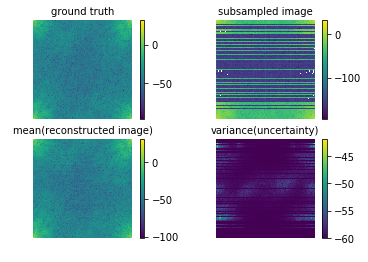

In [121]:

# plt.figure(figsize=(20,20))
plt.subplot(221)
fx = tensor_abs(torch.fft(to5d(x), signal_ndim = 2, normalized=True))[0,0]
plt.imshow(20*torch.log10(fx))
plt.title('ground truth',fontsize=10)
plt.colorbar()
plt.axis('off')

plt.subplot(222)
fy = tensor_abs(torch.fft(to5d(y2), signal_ndim = 2, normalized=True))[0,0]
plt.imshow(20*torch.log10(fy))
plt.title('subsampled image',fontsize=10)
plt.colorbar()
plt.axis('off')

plt.subplot(223)
plt.imshow(20*torch.log10(f_mean))
plt.colorbar()
plt.title('mean(reconstructed image)',fontsize=10)
plt.axis('off')

plt.subplot(224)
plt.imshow(20*torch.log10(f_var+1e-3))
plt.colorbar()
plt.title('variance(uncertainty)',fontsize=10)
plt.axis('off')

Text(0.5, 1.0, '1D Uncertainty')

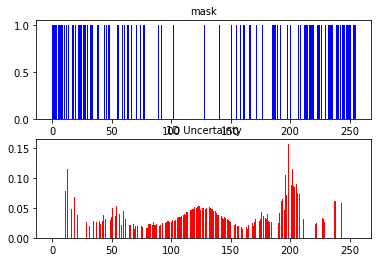

In [122]:

# plt.figure(figsize=(20,10))
plt.subplot(211)
plt.bar(np.arange(256), torch.sum(mask,1)>0,color='b')
plt.title('mask',fontsize=10)
plt.subplot(212)
plt.bar(np.arange(256), torch.sum(f_var, 1),color='r')
plt.title('1D Uncertainty',fontsize=10)
# plt.ylim([0,0.5])
# plt.bar(np.arange(256), torch.sum(fx*f_std,1),color='g')

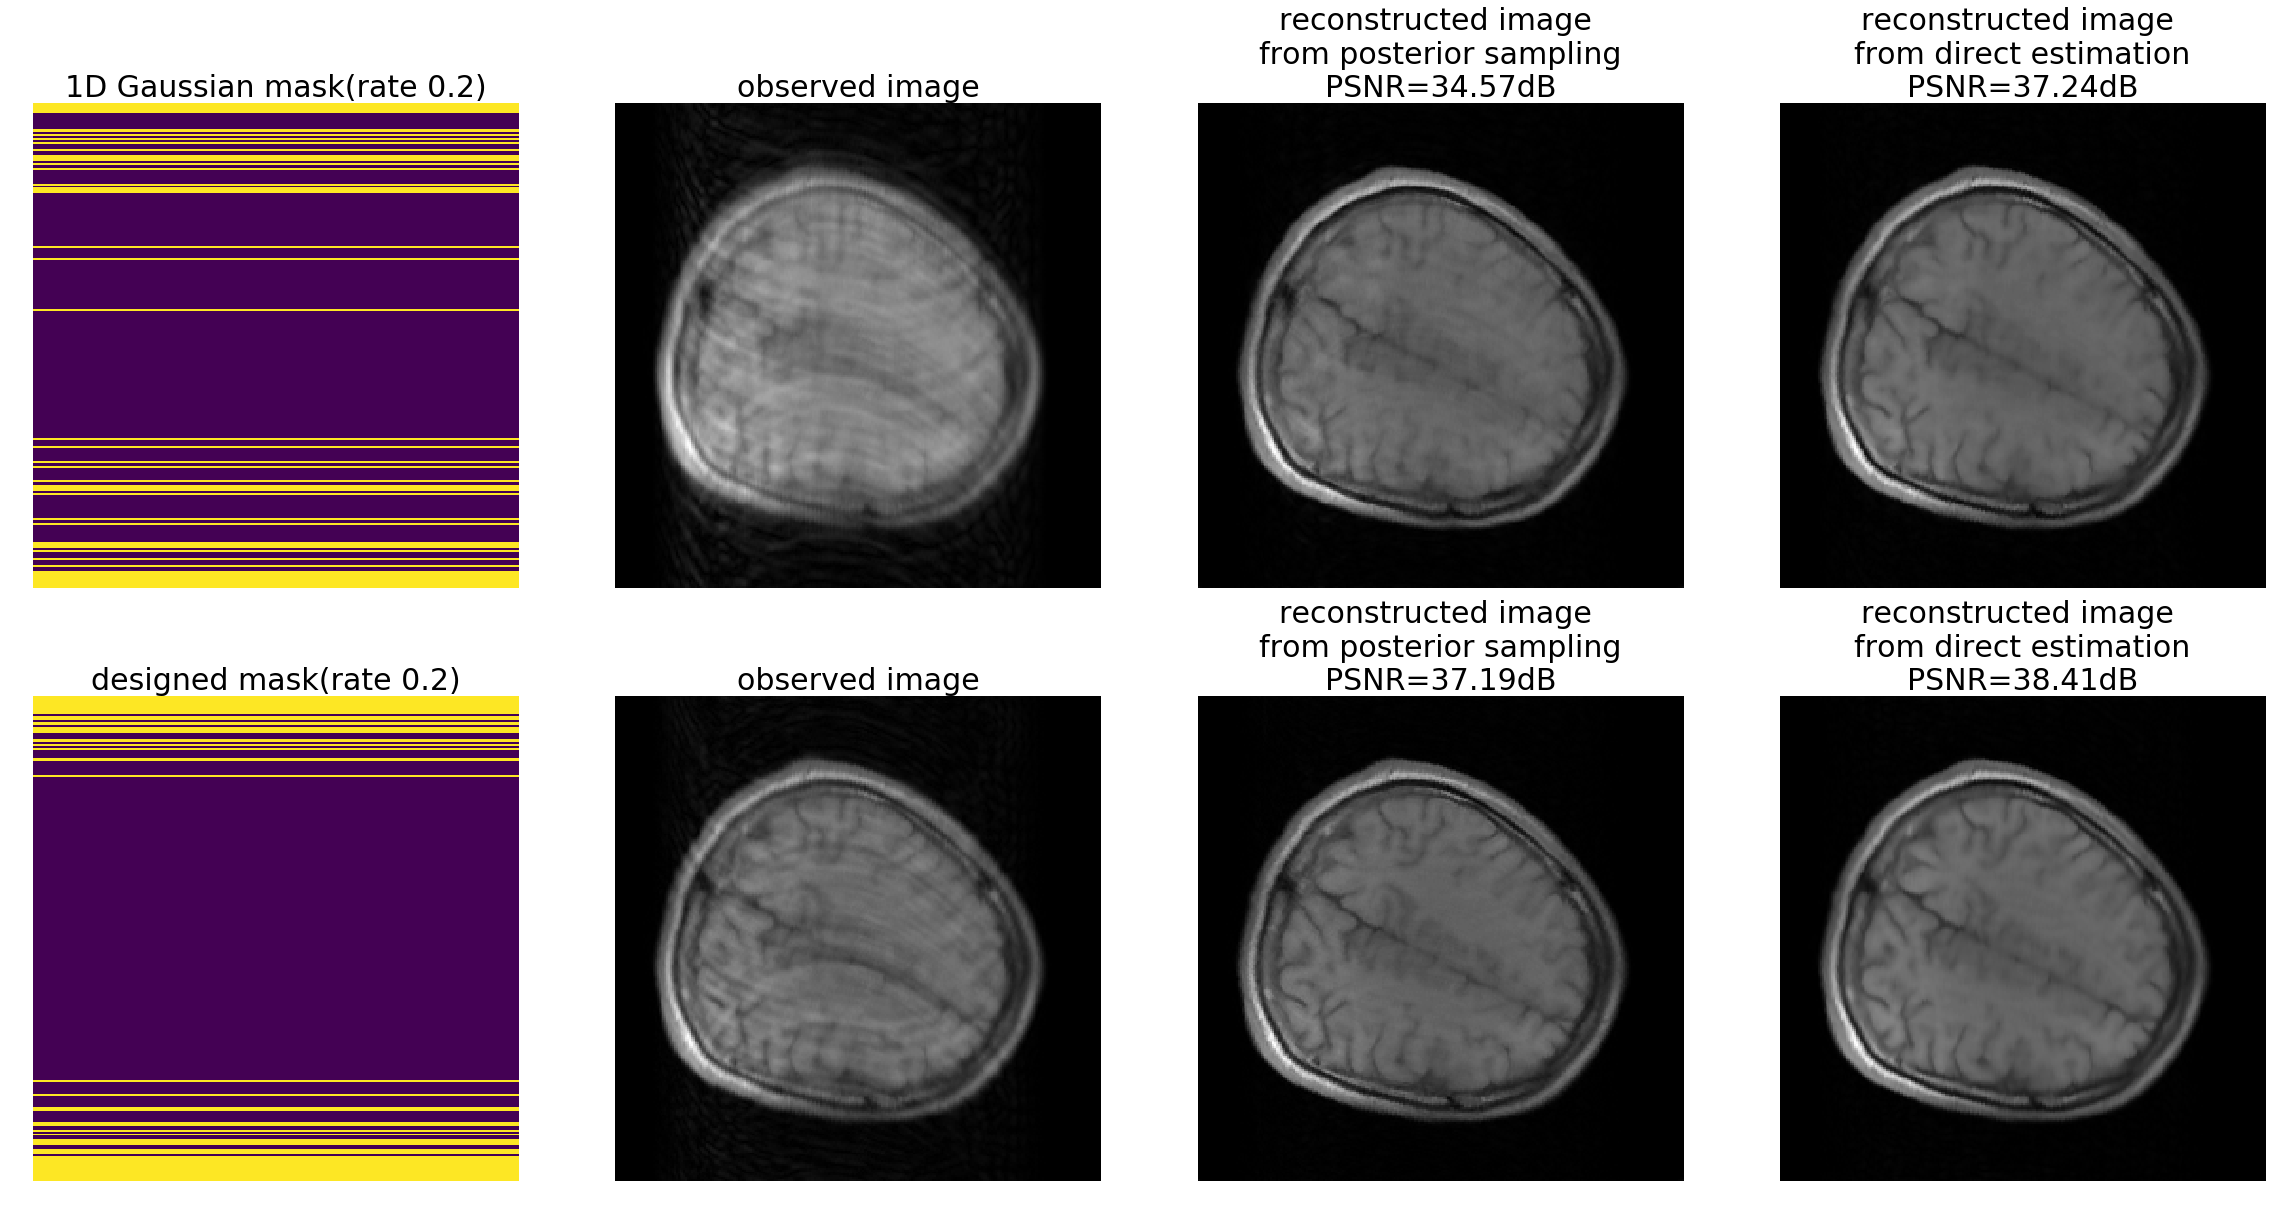

In [123]:
plt.figure(figsize=(40,20))

plt.subplot(241)
plt.imshow(ms)
# plt.colorbar()
plt.axis('off')
plt.title('1D Gaussian mask(rate 0.2)',fontsize=30)

plt.subplot(242)
inp1 = torch.sqrt(y1[0,0]**2+y1[0,1]**2)
plt.imshow(inp1, cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('observed image',fontsize=30)

plt.subplot(243)
outp1 = np.sqrt(mean1[0]**2+mean1[1]**2)
plt.imshow(outp1, cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('reconstructed image \nfrom posterior sampling\nPSNR=34.57dB',fontsize=30)

plt.subplot(244)
plt.imshow(torch.load('./results/gaussian.pt'), cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('reconstructed image \nfrom direct estimation\nPSNR=37.24dB',fontsize=30)

plt.subplot(245)
plt.imshow(g_mask)
# plt.colorbar()
plt.axis('off')
plt.title('designed mask(rate 0.2)',fontsize=30)

plt.subplot(246)
inp2 = torch.sqrt(y2[0,0]**2+y2[0,1]**2)
plt.imshow(inp2, cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('observed image',fontsize=30)

plt.subplot(247)
outp2 = np.sqrt(mean2[0]**2+mean2[1]**2)
plt.imshow(outp2, cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('reconstructed image \nfrom posterior sampling\nPSNR=37.19dB',fontsize=30)
# plt.savefig('./results/reconstruction.pdf')
# plt.subplot(325)

plt.subplot(248)
plt.imshow(torch.load('./results/designed.pt'), cmap='gray')
# plt.colorbar()
plt.axis('off')
plt.title('reconstructed image \nfrom direct estimation\nPSNR=38.41dB',fontsize=30)
           
gt = torch.sqrt(x[0,0]**2+x[0,1]**2)
# plt.savefig('./results/recon.pdf')
# plt.imshow(gt, cmap='gray')
# # plt.colorbar()
# plt.axis('off')

In [124]:
# mse_inp = torch.mean((y[0]-x[0])**2)
# mse_outp = torch.mean((torch.from_numpy(mean1)-x[0])**2)
# print('input mse %e'%(mse_inp.item()))
# print('output mse %e'%(mse_outp.item()))
psnr_input = psnr(inp1,gt)
psnr_output = psnr(torch.from_numpy(outp1),gt)
print('\ninput PSNR: %f dB'%(psnr_input))
print('output PSNR: %f dB'%(psnr_output))
print('\ninput SSIM: %f'%(ssim(gt.numpy(), inp1.numpy(), data_range=inp1.numpy().max()-inp1.numpy().min())))
print('output SSIM: %f'%(ssim(gt.numpy(), outp1, data_range=outp1.max()-outp1.min())))
print('\nsum of the variance: %f'%(np.sum(var1[0]+var1[1])))
gt_var1 = (x.numpy()-mean1)**2
gt_var1 = gt_var1[0, 0] + gt_var1[0, 1]
# print('mse between gt variance and predicted variance: %e'%np.mean(var1[0]+var1[1]-gt_var1)**2)


input PSNR: 27.251513 dB
output PSNR: 34.447723 dB

input SSIM: 0.578594
output SSIM: 0.866918

sum of the variance: 12.950737


In [125]:
# mse_inp = torch.mean((yt[img_idx]-xt[img_idx])**2)
# mse_outp = torch.mean((torch.from_numpy(mean2)-xt[img_idx])**2)
# print('input mse %e'%(mse_inp.item()))
# print('output mse %e'%(mse_outp.item()))
psnr_input = psnr(inp2,gt)
psnr_output = psnr(torch.from_numpy(outp2),gt)
print('\ninput PSNR: %f dB'%(psnr_input))
print('output PSNR: %f dB'%(psnr_output))
print('\ninput SSIM: %f'%(ssim(gt.numpy(), inp2.numpy(), data_range=inp2.numpy().max()-inp2.numpy().min())))
print('output SSIM: %f'%(ssim(gt.numpy(), outp1, data_range=outp2.max()-outp2.min())))
print('\nsum of the variance: %f'%(np.sum(var2[0]+var2[1])))
gt_var2 = (x.numpy()-mean2)**2
gt_var2 = gt_var2[0, 0] + gt_var2[0, 1]
# print('mse between gt variance and predicted variance: %e'%np.mean(var2[0]+var2[1]-gt_var2)**2)


input PSNR: 32.351574 dB
output PSNR: 40.345364 dB

input SSIM: 0.707966
output SSIM: 0.871671

sum of the variance: 5.208670


# Variance

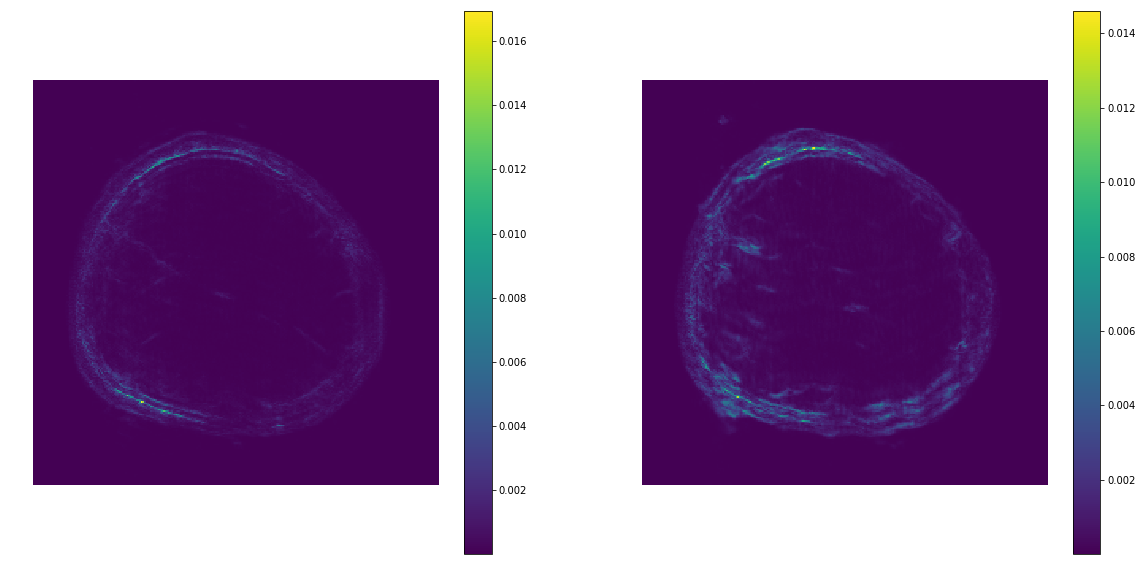

In [27]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(var1[0]+var1[1])
plt.colorbar()

plt.subplot(122)
plt.axis('off')
plt.imshow(var2[0]+var2[1])
plt.colorbar()

# Squared error

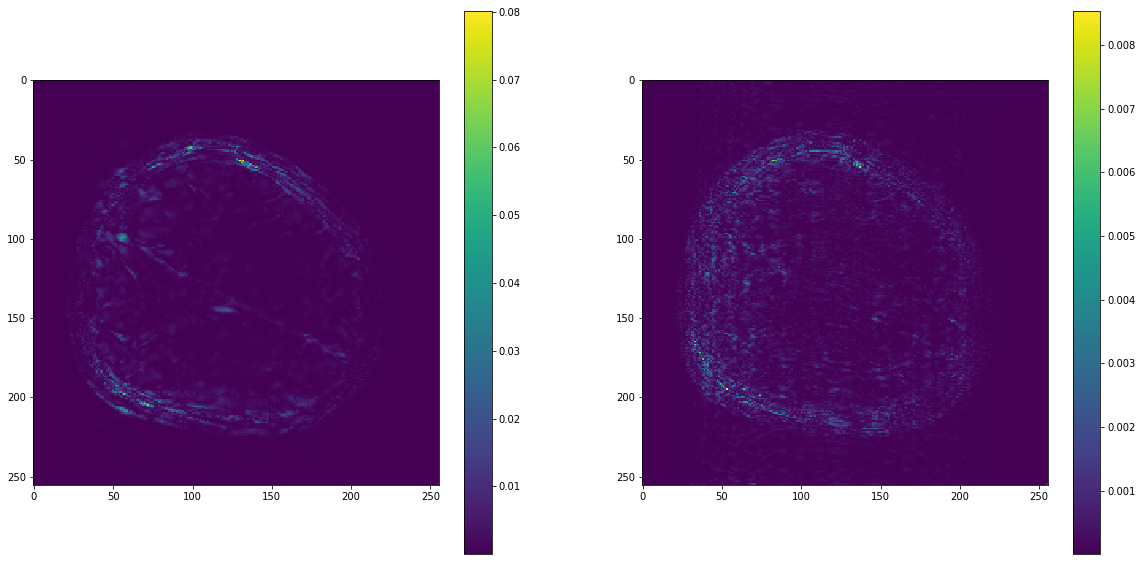

In [24]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(gt_var1)
plt.colorbar()
plt.subplot(122)
plt.imshow(gt_var2)
plt.colorbar()

# Standard deviation

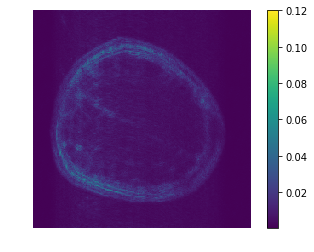

In [126]:
# plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(np.sqrt(var2[0]+var2[1]),vmax=0.12)
plt.colorbar()
plt.savefig('./results/std_50.pdf')

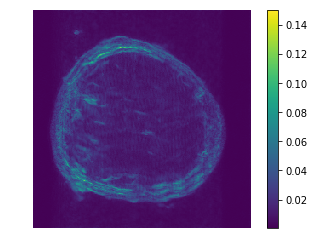

In [25]:
plt.axis('off')
plt.imshow(np.sqrt(var2[0]+var2[1]),vmax=0.15)
plt.colorbar()
# plt.title('Std for the mask with 0.1 undersampling rate',fontsize=15)

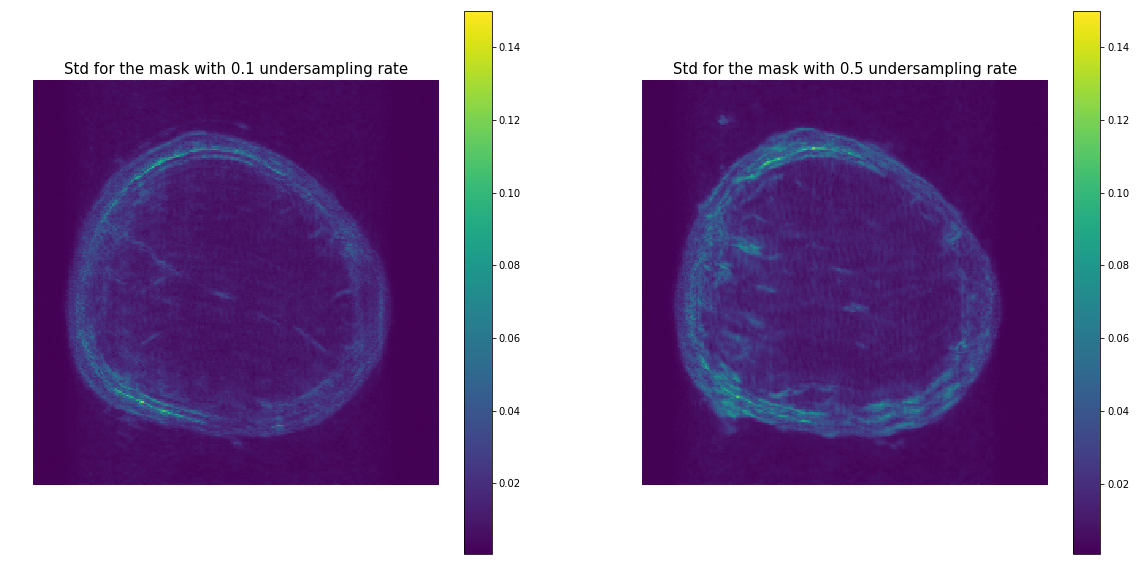

In [28]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.axis('off')
plt.imshow(np.sqrt(var1[0]+var1[1]),vmax=0.15)
plt.colorbar()
plt.title('Std for the mask with 0.1 undersampling rate',fontsize=15)

plt.subplot(122)
plt.axis('off')
plt.imshow(np.sqrt(var2[0]+var2[1]),vmax=0.15)
plt.colorbar()
plt.title('Std for the mask with 0.5 undersampling rate',fontsize=15)
plt.savefig('./results/std.pdf')

# Squared root error

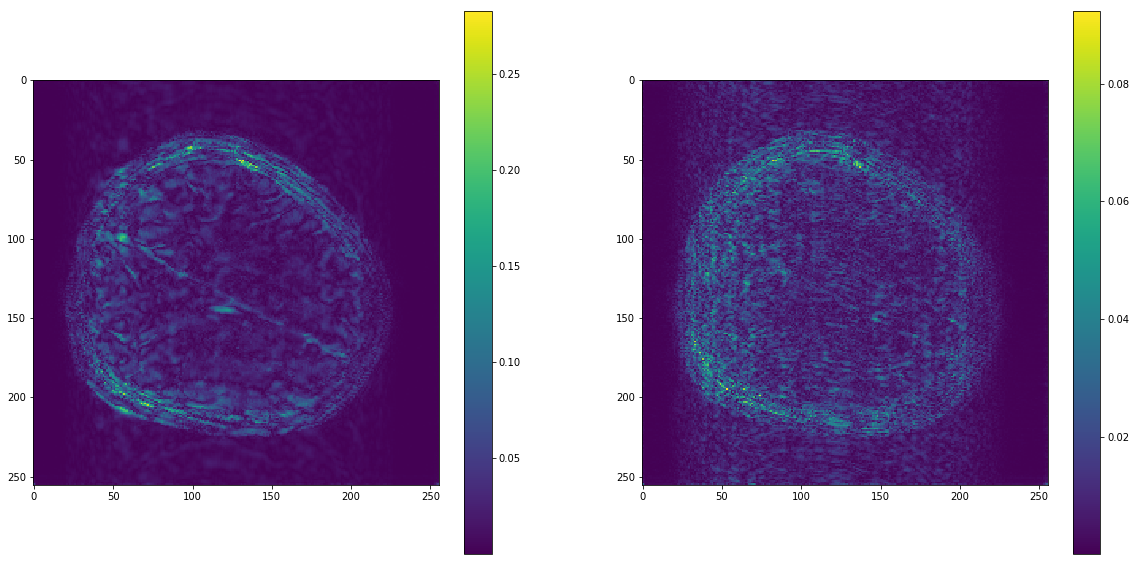

In [26]:
plt.figure(figsize=(20,10))
plt.subplot(121)
plt.imshow(np.sqrt(gt_var1))
plt.colorbar()
plt.subplot(122)
plt.imshow(np.sqrt(gt_var2))
plt.colorbar()

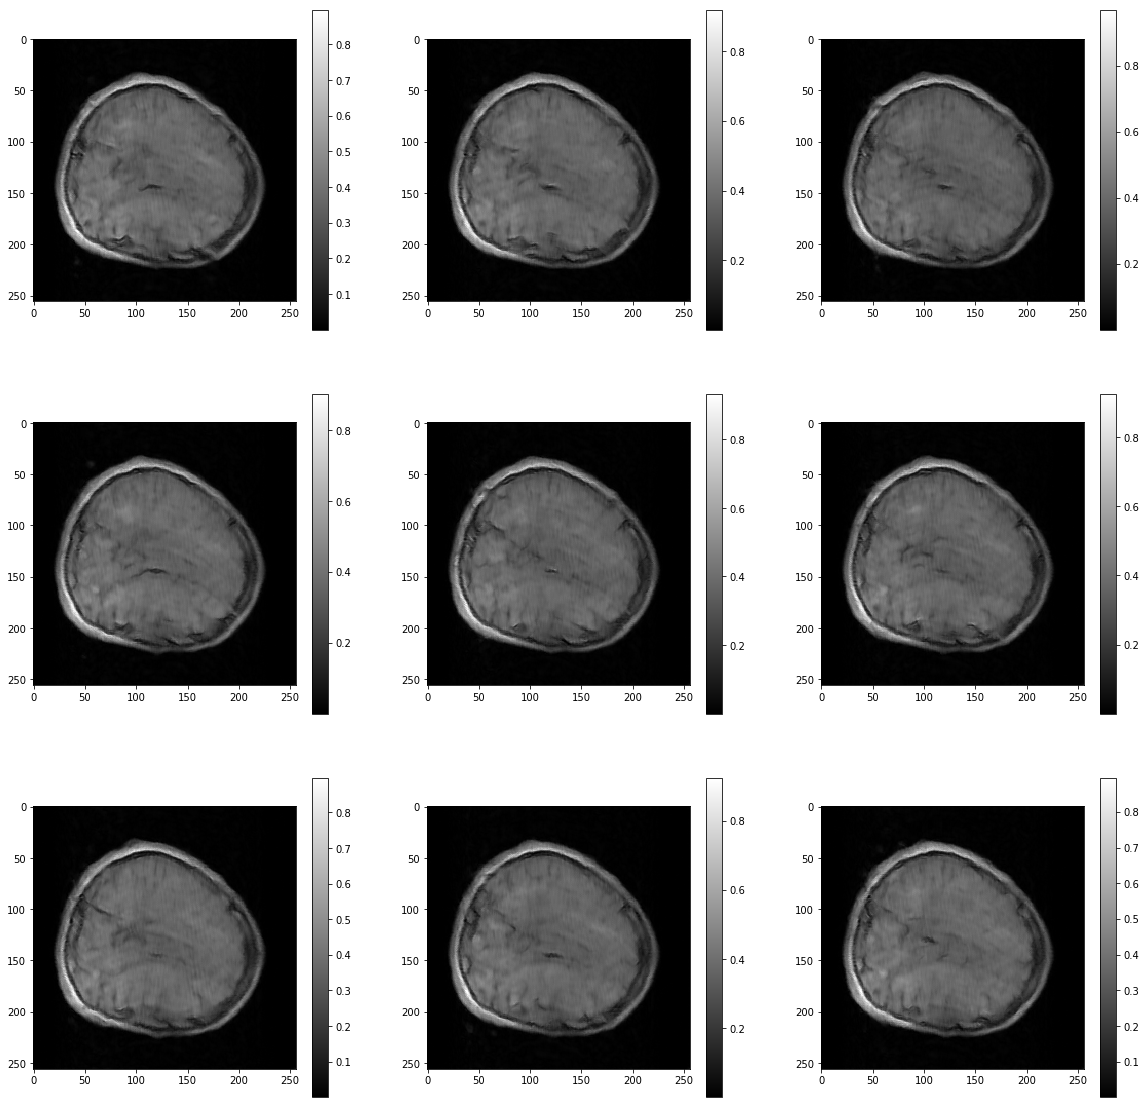

In [27]:
fig, _axes = plt.subplots(3,3,figsize=(20,20))
axes = _axes.flatten()
for i in range(9):
    a = axes[i].imshow(np.sqrt(outps1[i,0]**2+outps1[i,1]**2), cmap='gray')
    fig.colorbar(a, ax=axes[i])